In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

/home/amit/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
MEAN = 7
STD = 3

In [3]:
orig_sampler = lambda: np.random.normal(loc=MEAN, scale=STD)

In [4]:
orig_data = [orig_sampler() for _ in range(500)]

(array([  2.,  21.,  75., 117., 139.,  94.,  39.,   7.,   5.,   1.]),
 array([-2.10975982,  0.02060073,  2.15096127,  4.28132181,  6.41168236,
         8.5420429 , 10.67240344, 12.80276399, 14.93312453, 17.06348508,
        19.19384562]),
 <a list of 10 Patch objects>)

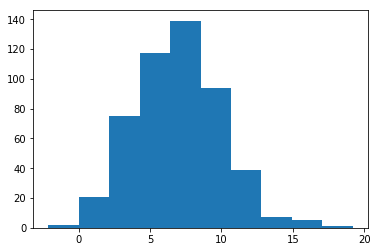

In [5]:
plt.hist(orig_data)

In [6]:
# create generator
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as _K
import tensorflow as tf
from keras.optimizers import Adam

G = Sequential()
G.add(Dense(8, activation='relu', input_dim=1))
G.add(Dense(1, activation='relu'))

G.summary()

G.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [7]:
from scipy import stats

MOMENTS_SIZE = 2

def get_moments(data):
#     print(data)
    mean = np.mean(data)
    std = np.std(data)
    # kurt = stats.kurtosis(data)
    # skew = stats.skew(data)
    # kurt = 1
    # skew = 1
    return np.array([mean, std]).reshape(1, 2)

In [8]:
get_moments([orig_sampler() for _ in range(50)])

array([[6.37879055, 3.71680771]])

In [9]:
D = Sequential()
D.add(Dense(10, activation='relu', input_dim=MOMENTS_SIZE))
D.add(Dense(8, activation='relu'))
D.add(Dense(1, activation='sigmoid'))

D.summary()

D.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


In [10]:
import pdb;
from keras.layers import Input, Lambda
from keras.models import Model

def get_moments_k(data):
    # print(data)
    mean = _K.mean(data, axis=-1, keepdims=True)
    std = _K.std(data, axis=-1, keepdims=True)
#     print(mean)
    # pdb.set_trace()
    # kurt = stats.kurtosis(data)
    # skew = stats.skew(data)
#     kurt = _K.constant(1)
#     skew = _K.constant(1)
    return _K.concatenate([mean, std])
#     return [mean, std, kurt, skew]

def apply_g(val):
#     print(val.shape)
    ret_val = G(_K.reshape(val, (1,1)))[0][0]
#     print(ret_val.shape)
#     ret_val = val
#     print(ret_val)
    return ret_val

# get combined G and D for training G
gan_input = Input(shape=(500,))
# x = G(gan_input)
# x = Lambda(lambda j: _K.concatenate([G(j) for _ in range(500)]))(gan_input)
x = Lambda(lambda j: _K.map_fn(lambda v: _K.map_fn(apply_g, v), j))(gan_input)
# x = gan_input
x = Lambda(lambda p: get_moments_k(p))(x)
gan_output = D(x)
C= Model(inputs=gan_input, outputs=gan_output)
C.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))
C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 500)               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 127       
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(10):
    print("Epoch #%d" % i)
    for j in range(20):
        # single epoch
        D.trainable = True
        real_data = [orig_sampler() for _ in range(500)]
        G_entropy = np.random.rand(500)
        fake_data = G.predict(G_entropy)

        real_moments = get_moments(real_data)
        fake_moments = get_moments(fake_data)

        D.fit(real_moments, np.ones(1), epochs=1, verbose=(1 if j == 19 else 0))
        D.fit(fake_moments, np.zeros(1), epochs=2, verbose=(1 if j == 19 else 0))
    for k in range(20):
        # train G
        D.trainable = False
        G_entropy = np.random.rand(500)
        # print(G_entropy.shape)
        C.fit(G_entropy.reshape(1, 500), np.ones(1), epochs=2, verbose=(1 if k == 19 else 0))

Epoch #0
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2290
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: 0.6918
Epoch 2/2
1/1 [==============================] - 0s 3ms/step - loss: 0.6917


/home/amit/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/2
1/1 [==============================] - 0s 89ms/step - loss: 0.6919
Epoch 2/2
1/1 [==============================] - 0s 99ms/step - loss: 0.6918
Epoch #1
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1243
Epoch 1/2
1/1 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 2/2
1/1 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 1/2
1/1 [==============================] - 0s 85ms/step - loss: 0.6866
Epoch 2/2
1/1 [==============================] - 0s 103ms/step - loss: 0.6864
Epoch #2
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0415
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: 0.6969
Epoch 2/2
1/1 [==============================] - 0s 3ms/step - loss: 0.6968
Epoch 1/2
1/1 [==============================] - 0s 90ms/step - loss: 0.6832
Epoch 2/2
1/1 [==============================] - 0s 99ms/step - loss: 0.6830
Epoch #3
Epoch 1/1
1/1 [==============================] - 0s 2m

In [ ]:
G_entropy = np.random.rand(500)
fake_data = G.predict(G_entropy)
plt.hist(fake_data)
fake_moments = get_moments(fake_data)
print(fake_moments)
print(D.predict(fake_moments))